In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from Conv_tnn import DoG
mnist = fetch_mldata('MNIST original')
N, _ = mnist.data.shape

# Reshape the data to be square
mnist.square_data = mnist.data.reshape(N,28,28)

In [6]:
mnist.target

array([0., 0., 0., ..., 9., 9., 9.])

In [2]:
layer = DoG(layer_name='DoG', threshold=None)

In [3]:
result = layer(mnist.square_data[0])

In [4]:
result.shape
result.max()

7.0

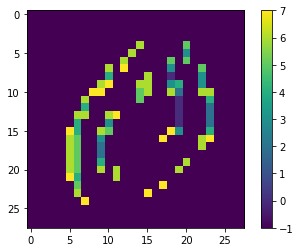

In [6]:
plt.imshow(result[:,:,1])
plt.colorbar()
plt.show()

In [61]:
A = np.random.randint(low=1, high=7, size=(4,3,3))
for i in range(A.shape[1]):
    for j in range(A.shape[2]):
        if (i%2 != j%2):
            A[:, i, j] = 0

In [62]:
#A[:, int(A.shape[1]/2), int(A.shape[1]/2)] = 0
A

array([[[4, 0, 4],
        [0, 5, 0],
        [2, 0, 4]],

       [[3, 0, 3],
        [0, 1, 0],
        [6, 0, 6]],

       [[4, 0, 1],
        [0, 5, 0],
        [5, 0, 6]],

       [[2, 0, 1],
        [0, 1, 0],
        [3, 0, 6]]])

In [74]:
a = np.zeros((3,3,6))
a[0,0,:].shape

(6,)

In [65]:
a[[1,3,0]] = 1
a/a.sum()

array([0.33333333, 0.33333333, 0.        , 0.33333333, 0.        ,
       0.        ])

In [73]:
np.random.choice(6, 1, p=a/a.sum())[0] 

0

In [44]:
import math
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from collections import deque
from sklearn.datasets import fetch_mldata
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
MAX_TIME = 32
MAX_ITERATION = 50




def rconv(size):
    result = np.zeros(size)
    mid = int(size/2)
    left, right = mid-1, mid+1
    i = 1
    while left >=0 and right <=size-1:
        result[left] = -i
        result[right] = i
        left -= 1
        right += 1
        i += 1
    return result.astype('int')

class Layer():
    def __init__(self, layer_name, threshold):
        self.layer_name = layer_name
        self.threshold = threshold

    def __call__(self, x):
        return self.forward(x)

    def reset(self):
        # Reset the network, clearing out any accumulator variables, etc
        pass

    def forward(self, x):
        """
        This function will control the different processing steps for a
        single image

        """
        pass

class DoG(Layer):
    def __init__(self, layer_name, threshold, mode, s1,s2):
        super(DoG, self).__init__(layer_name, threshold)
        self.on_kernel = None 
        self.off_kernel = None 
        self.mode = mode
        self.s1 = s1
        self.s2 = s2
        self._build_kernel()

    def _build_kernel(self):
        self.on_kernel = self._build_filter(3)
        self.off_kernel = -self.on_kernel
        
    def _conv(self, x):
        return np.array([np.matmul(x, self.on_kernel).sum(), np.matmul(x, self.off_kernel).sum()]).reshape(1, 2)

    def _build_filter(self, size):
        r = np.arange(size)+1
        x = np.tile(r, [size, 1])
        y = x.T
        d2 = (x-size/2.-0.5)**2 + (y-size/2.-0.5)**2
        filt = 1/np.sqrt(2*np.pi) * (1/self.s1 * np.exp(-d2/(2*(self.s1**2))) - 1/self.s2 * np.exp(-d2/(2*(self.s2**2))))
        filt -= np.mean(filt[:])
        filt /= np.amax(filt[:])
        return filt

    def _generate_spike(self, x, num_bits):
        x[x<1] = -1
        spiketimes = np.zeros(x.shape)        
        # Make large numbers represent earlier spikes (largest value maps to spike
        # at time 0), and vice versa
        spiketimes = np.full(x.shape, np.amax(x)) - x

        # Negative values map to no spikes
        spiketimes[x < 0] = -1
        spiketimes[spiketimes > 2 ** num_bits] = -1
        spiketimes = np.round(spiketimes)
        # We set 0 as no spike and the minimum spiketime starts from 1 and ends at 2 ** num_bits
        # This is mainly for the simplicity 
        if self.mode == 'Full':
            return spiketimes+1
        elif self.mode == 'On':
            return spiketimes[:,:,:1]+1
        else:
            return spiketimes[:,:,1:]+1
        
    def forward(self, x, num_bits=5):
        a = []
        for i in range(2 ** num_bits):
            a += [i] * int(256/(2 ** num_bits))
        a = np.asarray(a)
        scaled_data = a[x]
        W, H = scaled_data.shape

        filtered_data = np.zeros((W, H, 2))
        padded_data = np.pad(scaled_data,
                            ((1, 1), (1, 1)),
                            'constant',
                            constant_values=0) #deal with the edge by padding around
        for i in range(1, padded_data.shape[0]-1):
            for j in range(1, padded_data.shape[1]-1):
                filtered_data[i-1, j-1, :] = self._conv(padded_data[i-1:i+2, j-1:j+2])

        return self._generate_spike(filtered_data, num_bits=num_bits)

class Conv(Layer):
    def __init__(self, layer_name, threshold, mode, size, stride, pad):
        super(Conv, self).__init__(layer_name, threshold)
        self.mode = mode
        self.stride = stride
        self.pad = pad
        self.size = size 
        self.threshold = threshold
        self.rf = self._rf_init()
        C1, C2, W, H = self.rf.shape # C1, dim of cur layer, C2 dim of pre layer
        self.weights = (0.8+np.random.randn(C1, C2, W, H) * 0.05)
        self.weights[self.weights >= 1.] = 0.99
        self.weights[self.weights <= 0.] = 0.01
        self.weights *= self.rf

        self.rf = self.rf[0][0] # W x H
        self.presynaptic = None
        self.postsynaptic = None
        self.aplus = 4e-3
        self.aminus = 3e-3
        self.dw = np.zeros_like(self.weights)
        self.inter_threshold = 3
        self.IL = LI(layer_name=self.layer_name+'_LI')
    
    def clear_dw(self):
        self.dw = np.zeros_like(self.weights)

    def _rf_init(self):
        '''
            size should be Channel First. e.g: 4x4x3x3
            mode: 
            Full: all receptive filed
            Cornel: e.g.:   [1, 0, 1],
                            [0, 0, 0],
                            [1, 0, 1]]
            Center: e.g.:   [1, 0, 1],
                            [0, 1, 0],
                            [1, 0, 1]]

        '''
        kernel = np.ones(self.size)
        if self.mode == 'Full':
            return kernel 
        if self.mode == 'Corner':
            for i in range(kernel.shape[2]):
                for j in range(kernel.shape[3]):
                    if (i%2 != j%2):
                        kernel[:, :, i, j] = 0    
            kernel[:, :, int(kernel.shape[1]/2), int(kernel.shape[1]/2)] = 0   
            return kernel    
        if self.mode == 'Center':
            for i in range(kernel.shape[2]):
                for j in range(kernel.shape[3]):
                    if (i%2 != j%2):
                        kernel[:, :, i, j] = 0    
            return kernel   
    
    def _conv(self, window, weights, potentials=None):
        '''
        window: WxHxC2 input window
        weights: C2xWxH  corresponding weights
        potentials: initial potentials
        '''
        if potentials is None:
            potentials = np.zeros(MAX_TIME)    
        x = np.transpose(window, (2,0,1)) # transpose to channel first 
        for k in range(x.shape[0]):
            channel = self.rf * x[k, :, :]
            for i in range(channel.shape[0]):
                for j in range(channel.shape[1]):
                    if channel[i][j]:
                        potentials[int(channel[i][j])-1:] += weights[k][i][j]
        diff = potentials > self.threshold
        if True in diff:
            return np.where(diff == True)[0][0] + 1
        else:
            return 0
        
    def forward(self, x):
        self.presynaptic = x
        W, H, C = x.shape
        Wout = (int(W - self.size[2] + 2*self.pad) / self.stride) + 1
        Hout = (int(H - self.size[3] + 2*self.pad) / self.stride) + 1
        Cout = self.size[0]
        Wout, Hout, Cout = int(Wout), int(Hout), int(Cout)
        result = np.zeros((Wout, Hout, Cout))
        w = int(self.rf.shape[0]/2)
        h = int(self.rf.shape[1]/2)
        x = np.pad(x, ((self.pad, self.pad), (self.pad, self.pad), (0, 0)), 'constant', constant_values=0) #deal with the edge by padding around  
        for k in range(self.size[0]): # for each filter
            for i in range(w, x.shape[0]-w, self.stride):
                for j in range(h, x.shape[1]-h, self.stride):
                    window = x[i-w:i+w+1, j-h:j+h+1, :]
                    result[int((i-w)/self.stride), int((j-h)/self.stride), k] = self._conv(window.copy(), self.weights[k])
        self.postsynaptic = self.IL(result)
        return self.postsynaptic
    
    def stdp_update(self):
        self.clear_dw()
        inter_competition = deque()
        for k in range(self.postsynaptic.shape[2]): # for each filter
            feature_map = self.postsynaptic[:,:,k]
            if np.nonzero(feature_map)[0].shape[0]:
                minval = np.min(feature_map[np.nonzero(feature_map)])
                xs, ys = np.where(feature_map == minval)
                for m in range(MAX_ITERATION):
                    stdp_index = np.random.choice(len(xs))
                    stdp_x = xs[stdp_index]
                    stdp_y = ys[stdp_index]    
                    if (stdp_x, stdp_y) not in inter_competition:
                        break 
                if m == MAX_ITERATION - 1:
                    continue
                else:
                    if len(inter_competition) < self.inter_threshold:
                        inter_competition.append((stdp_x, stdp_y))
                    else:
                        inter_competition.popleft()
                        inter_competition.append((stdp_x, stdp_y))   
                    
                    Ti = self.postsynaptic[stdp_x, stdp_y, k]
                    j_list = rconv(self.size[-1])
                    for m in j_list:
                        for n in j_list:
                            for l in range(self.presynaptic.shape[-1]):
                                Tj = self.presynaptic[stdp_x+m, stdp_y+n, l]
                                if Tj - Ti <= 0:
                                    self.dw[k, l, m+int(self.size[-1]/2),n+int(self.size[-1]/2)] += self.aplus * self.weights[k, l, m+int(self.size[-1]/2),n+int(self.size[-1]/2)] * (1-self.weights[k, l, m+int(self.size[-1]/2),n+int(self.size[-1]/2)])
                                else:
                                    self.dw[k, l, m+int(self.size[-1]/2),n+int(self.size[-1]/2)] += self.aminus * self.weights[k, l, m+int(self.size[-1]/2),n+int(self.size[-1]/2)] * (1-self.weights[k, l, m+int(self.size[-1]/2),n+int(self.size[-1]/2)]) 
                                            
        self.weights += self.dw 

class LI(Layer):
    def __init__(self, layer_name):
        super(LI, self).__init__(layer_name, None)
        
    def forward(self, x):
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                if np.sum(x[i, j, :]):
                    a = x[i, j, :]
                    fire_id = np.random.choice(a.shape[0], 1, p=a/a.sum())[0]     
                    mask = np.zeros_like(a)  
                    mask[fire_id] += 1
                    x[i, j, :] *= mask
        return x

class MaxPool(Layer):
    def __init__(self, layer_name, size, stride):
        super(MaxPool, self).__init__(layer_name, None)
        self.size = size
        self.stride = stride

    def _pool(self, window):
        window = window.flatten()
        window = np.sort(window)
        for x in window:
            if x > 0:
                return x
        return 0


    def forward(self, x):
        W, H, C = x.shape
        Wout = (int(W - self.size) / self.stride) + 1
        Hout = (int(H - self.size) / self.stride) + 1
        Cout = C
        Wout, Hout, Cout = int(Wout), int(Hout), int(Cout)
        result = np.zeros((Wout, Hout, Cout)) #channel first
        print (result.shape)
        w = int(self.size/2)
        h = int(self.size/2)       
        for k in range(C): # for each filter
            for i in range(w, W-w, self.stride):
                for j in range(h, H-h, self.stride):
                    window = x[i-w:i+w+1, j-h:j+h+1, k]
                    result[int((i-w)/self.stride), int((j-h)/self.stride), k] = self._pool(window.copy())            
        return result           

class GlobalMaxPool(Layer):
    def __init__(self, layer_name, mode, threshold, size, stride, pad):
        super(GlobalMaxPool, self).__init__(layer_name, threshold)
        self.mode = mode
        self.stride = stride
        self.pad = pad
        self.size = size 
        self.threshold = threshold
        self.rf = self._rf_init()
        C1, C2, W, H = self.rf.shape # C1, dim of cur layer, C2 dim of pre layer
        self.weights = (0.8+np.random.randn(C1, C2, W, H) * 0.05)
        self.weights[self.weights >= 1.] = 0.99
        self.weights[self.weights <= 0.] = 0.01
        self.weights *= self.rf

        self.rf = self.rf[0][0] # W x H
        self.presynaptic = None
        self.postsynaptic = None
        self.aplus = 4e-3
        self.aminus = 3e-3
        self.dw = np.zeros_like(self.weights)
        self.inter_threshold = 3
        self.IL = LI(layer_name=self.layer_name+'_LI')
    
    def __call__(self, x, training):
        return self.forward(x, training) 

    def clear_dw(self):
        self.dw = np.zeros_like(self.weights)

    def _rf_init(self):
        '''
            size should be Channel First. e.g: 4x3x3
            mode: 
            Full: all receptive filed
            Cornel: e.g.:   [1, 0, 1],
                            [0, 0, 0],
                            [1, 0, 1]]
            Center: e.g.:   [1, 0, 1],
                            [0, 1, 0],
                            [1, 0, 1]]

        '''
        kernel = np.ones(self.size)
        if self.mode == 'Full':
            return kernel 
        if self.mode == 'Corner':
            for i in range(kernel.shape[1]):
                for j in range(kernel.shape[2]):
                    if (i%2 != j%2):
                        kernel[:, i, j] = 0    
            kernel[:, int(kernel.shape[1]/2), int(kernel.shape[1]/2)] = 0   
            return kernel    
        if self.mode == 'Center':
            for i in range(kernel.shape[1]):
                for j in range(kernel.shape[2]):
                    if (i%2 != j%2):
                        kernel[:, i, j] = 0    
            return kernel   
        
    def _conv(self, window, weights, training, potentials=None):
        '''
        window: WxHxC2 input window
        weights: C2xWxH  corresponding weights
        potentials: initial potentials
        '''
        if potentials is None:
            potentials = np.zeros(MAX_TIME)    
        x = np.transpose(window, (2,0,1)) # transpose to channel first 
        for k in range(x.shape[0]):
            channel = self.rf * x[k, :, :]
            for i in range(channel.shape[0]):
                for j in range(channel.shape[1]):
                    if channel[i][j]:
                        potentials[int(channel[i][j])-1:] += weights[k][i][j]
        if training: # Learning
            diff = potentials > self.threshold
            if True in diff:
                return np.where(diff == True)[0][0] + 1
            else:
                return 0
        else: # Pooling
            return potentials[-1]
    
    def _pool(self, x):
        W, H, C = x.shape
        result = np.zeros(C)
        for k in range(C):
            result[k] += np.amax(x[:,:,k])
        return result
        
    def forward(self, x, training=True):
        self.presynaptic = x
        W, H, C = x.shape
        Wout = (int(W - self.size[2] + 2*self.pad) / self.stride) + 1
        Hout = (int(H - self.size[3] + 2*self.pad) / self.stride) + 1
        Cout = self.size[0]
        Wout, Hout, Cout = int(Wout), int(Hout), int(Cout)
        result = np.zeros((Wout, Hout, Cout))
        w = int(self.rf.shape[0]/2)
        h = int(self.rf.shape[1]/2)
        x = np.pad(x, ((self.pad, self.pad), (self.pad, self.pad), (0, 0)), 'constant', constant_values=0) #deal with the edge by padding around  
        for k in range(self.size[0]): # for each filter
            for i in range(w, x.shape[0]-w, self.stride):
                for j in range(h, x.shape[1]-h, self.stride):
                    window = x[i-w:i+w+1, j-h:j+h+1, :]
                    result[int((i-w)/self.stride), int((j-h)/self.stride), k] = self._conv(window.copy(), self.weights[k], training)
        self.postsynaptic = self.IL(result)
        return self.postsynaptic if training else self._pool(result)

    def stdp_update(self):
        self.clear_dw()
        inter_competition = deque()
        for k in range(self.postsynaptic.shape[2]): # for each filter
            feature_map = self.postsynaptic[:,:,k]
            if np.nonzero(feature_map)[0].shape[0]:
                minval = np.min(feature_map[np.nonzero(feature_map)])
                xs, ys = np.where(feature_map == minval)
                for m in range(MAX_ITERATION):
                    stdp_index = np.random.choice(len(xs))
                    stdp_x = xs[stdp_index]
                    stdp_y = ys[stdp_index]    
                    if (stdp_x, stdp_y) not in inter_competition:
                        break 
                if m == MAX_ITERATION - 1:
                    continue
                else:
                    if len(inter_competition) < self.inter_threshold:
                        inter_competition.append((stdp_x, stdp_y))
                    else:
                        inter_competition.popleft()
                        inter_competition.append((stdp_x, stdp_y))   
                    
                    Ti = self.postsynaptic[stdp_x, stdp_y, k]
                    j_list = rconv(self.size[-1])
                    for m in j_list:
                        for n in j_list:
                            for l in range(self.presynaptic.shape[-1]):
                                Tj = self.presynaptic[stdp_x+m, stdp_y+n, l]
                                if Tj - Ti <= 0:
                                    self.dw[k, l, m+int(self.size[-1]/2),n+int(self.size[-1]/2)] += self.aplus * self.weights[k, l, m+int(self.size[-1]/2),n+int(self.size[-1]/2)] * (1-self.weights[k, l, m+int(self.size[-1]/2),n+int(self.size[-1]/2)])
                                else:
                                    self.dw[k, l, m+int(self.size[-1]/2),n+int(self.size[-1]/2)] += self.aminus * self.weights[k, l, m+int(self.size[-1]/2),n+int(self.size[-1]/2)] * (1-self.weights[k, l, m+int(self.size[-1]/2),n+int(self.size[-1]/2)]) 
                                            
        self.weights += self.dw 

class MNISTmodel():
    def __init__(self):
        self.model = self._buildmodel()
        self.clf = svm.SVC(gamma='scale')

    def __call__(self, x):
        self.forward(x)
    
    def _buildmodel(self):
        layer = []
        layer.append(DoG(layer_name='DoG', threshold=None, mode='Full', s1=1, s2=2))
        layer.append(Conv(layer_name='conv1', threshold=15, mode='Full', size=(30,2,5,5), stride=2, pad=2))
        layer.append(MaxPool(layer_name='pool', size=2, stride=2))
        layer.append(GlobalMaxPool(layer_name='conv2_GMP', threshold=10, mode='Full', size=(100,30,5,5), stride=2, pad=2))
        model = {layer[i].layer_name:layer[i] for i in range(len(layer))}     
        return model   
    
    def forward(self, x):
        if self.model is not None:
            for k, v in self.model.items():
                if 'GMP' in k:
                    x = v(x, training=True)
                else:
                    x = v(x)
        return x

    def inference(self, x):
        if self.model is not None:
            for k, v in self.model.items():
                if 'GMP' in k:
                    return v(x, training=False)
                else:
                    x = v(x)
    
    def learn(self):
        if self.model is not None:
            for k, v in self.model.items():
                if 'conv' in k:
                    self.model[k].stdp_update()
    
    def train_svm(self, x, y):
        self.clf.fit(x, y)  
    
    def test_svm(self, x, y):
        pred = self.clf.predict(x)
        acc = accuracy_score(y, pred)
        print ("Test accuracy of SVM is %f" % acc)

    def train(self, data, labels):
        print ("CTNN Training starts ...")
        for x in tqdm(data):
            self.forward(x)
            self.learn()
        print ("CTNN Training CTNN is finished")
        print ("SVM Training starts")
        y = []
        for x in tqdm(data):
            y.append(self.inference(x)) 
        self.train_svm(y, labels)
        print ("SVM Training is finished")

    def test(self, data, labels):
        y = []
        for x in tqdm(data):
            y.append(self.inference(x))

        self.test_svm(y, labels)
        print ("Test is finished")   






In [45]:
if __name__ == "__main__":
    Net = MNISTmodel()
    mnist = fetch_mldata('MNIST original')
    N, _ = mnist.data.shape

    # Reshape the data to be square
    mnist.square_data = mnist.data.reshape(N,28,28)
    X_train, X_test, y_train, y_test = train_test_split(mnist.square_data, 
                                                        mnist.target, 
                                                        test_size=0.3, 
                                                        random_state=42)
    Net.train(X_train, y_train)
    Net.test(X_test, y_test)



  0%|          | 0/49000 [00:00<?, ?it/s]

CTNN Training starts ...
(7, 7, 30)


  0%|          | 1/49000 [00:01<14:04:33,  1.03s/it]

(7, 7, 30)


  0%|          | 2/49000 [00:02<14:02:22,  1.03s/it]

(7, 7, 30)


  0%|          | 3/49000 [00:03<13:59:04,  1.03s/it]

(7, 7, 30)


  0%|          | 4/49000 [00:04<14:11:33,  1.04s/it]

(7, 7, 30)


  0%|          | 5/49000 [00:05<13:59:12,  1.03s/it]

(7, 7, 30)


  0%|          | 6/49000 [00:06<13:41:00,  1.01s/it]

(7, 7, 30)


  0%|          | 7/49000 [00:07<14:13:20,  1.05s/it]

(7, 7, 30)


KeyboardInterrupt: 

In [20]:
mnist = fetch_mldata('MNIST original')
N, _ = mnist.data.shape

# Reshape the data to be square
mnist.square_data = mnist.data.reshape(N,28,28)
layer1 = DoG(layer_name='DoG', threshold=None, mode='Full', s1=1, s2=2)
layer2 = Conv(layer_name='conv1', threshold=2, mode='Full', size=(3,2,3,3), stride=1, pad=2)
layer3 = MaxPool(layer_name='conv1_pool', size=3, stride=4)
layer4 = GlobalMaxPool(layer_name='GMP', mode='Full', size=(2,3,5,5), threshold=2, stride=1, pad=1)

In [15]:
def Model():
    layer = []
    layer.append(DoG(layer_name='DoG', threshold=None, mode='Full', s1=1, s2=2))
    layer.append(Conv(layer_name='conv1', threshold=19, mode='Full', size=(7,2,5,5), stride=1, pad=1))
    layer.append(LI(layer_name='conv1_LI'))
    layer.append(MaxPool(layer_name='conv1_pool', size=3, stride=2))
    
    layer.append(Conv(layer_name='conv2', threshold=19, mode='Full', size=(16,7,3,3), stride=1, pad=1))
    layer.append(LI(layer_name='conv2_LI'))
    layer.append(MaxPool(layer_name='conv2_pool', size=3, stride=2))
    
    layer.append(Conv(layer_name='conv3', threshold=19, mode='Full', size=(32,16,3,3), stride=1, pad=1))
    
    model = {layer[i].layer_name:layer[i] for i in range(len(layer))}
    return model
        
    

In [16]:
model = Model()

In [17]:
model['conv1'].weights.shape

(7, 2, 5, 5)

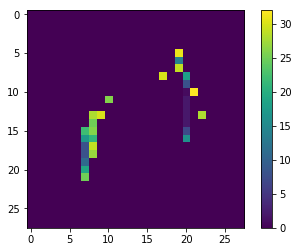

In [21]:
result = layer1(mnist.square_data[0])

plt.imshow(result[:,:,0])
plt.colorbar()
plt.show()

In [22]:
result.shape

(28, 28, 2)

In [23]:
result2 = layer2(result)

In [62]:
result5 = layer5(result, training=False)

In [63]:
result5

array([12.79320088, 12.95217106])

In [93]:
result2.shape

(28, 28, 3)

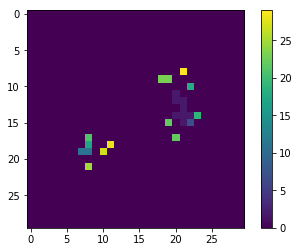

In [24]:
plt.imshow(result2[:,:,2])
plt.colorbar()
plt.show()

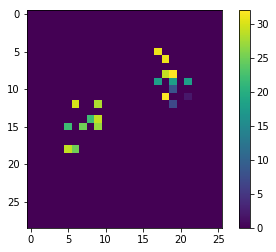

In [23]:
result3 = layer3(result2)
plt.imshow(result3[:,:,])
plt.colorbar()
plt.show()

In [128]:
result4 = layer3(result2)

(7, 7, 3)


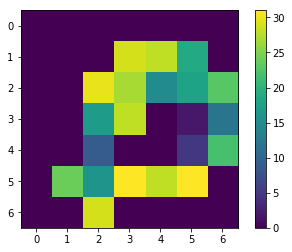

In [130]:
plt.imshow(result4[:,:,2])
plt.colorbar()
plt.show()

In [25]:
layer2.stdp_update()

In [768]:
import numpy as np
import numpy.ma as ma
a = np.random.randint(low=0, high=5, size=(3,2,2))

print ("your array: ",a)

# the non-zero minimum value
minval = np.min(ma.masked_where(a==0, a)) 
print ("non-zero minimum: ",minval)

# the position/index of non-zero  minimum value in the array
minvalpos = np.argmin(ma.masked_where(a==0, a))  
print ("index of non-zero minimum: ", minvalpos)

your array:  [[[4 2]
  [0 3]]

 [[1 0]
  [4 2]]

 [[4 3]
  [2 1]]]
non-zero minimum:  1
index of non-zero minimum:  4


In [472]:
a = np.random.randint(low=0, high=5, size=(2,2))
minval = np.min(a[np.nonzero(a)])
if minval:
    xs, ys = np.where(a == minval)
    stdp_index = np.random.choice(len(xs))
    stdp_x = xs[stdp_index]
    stdp_y = ys[stdp_index]
    

[[4 0]
 [0 1]]
[1] [1]
0
1 1


In [451]:
minval = np.min(a[np.nonzero(a)])

In [443]:
minval

2

In [444]:
np.where(a == minval)

(array([0, 1]), array([1, 0]))

In [476]:
from collections import deque
q = deque()
for i in range(5):
    if len(q) < 3:
        q.append((i, i))
    else:
        q.popleft()
        q.append((i,i))
print (q)
    

deque([(2, 2), (3, 3), (4, 4)])


In [485]:
rf = np.zeros((5,2))

A = (0.8+np.random.randn(5,2) * 0.05)

In [86]:
def rconv(size):
    result = np.zeros(size)
    mid = int(size/2)
    left, right = mid-1, mid+1
    i = 1
    while left >=0 and right <=size-1:
        result[left] = -i
        result[right] = i
        left -= 1
        right += 1
        i += 1
    return result.astype('int')

In [87]:
rconv(5)

array([-2, -1,  0,  1,  2])